In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import load_model


# Setzen des Seeds für Reproduzierbarkeit
def set_seed(seed=123):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(123)

## Daten lesen und vorbereiten


In [2]:
base_dir = '/Users/mohini/Library/Mobile Documents/com~apple~CloudDocs/ML_Projekt_Handschrift/dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


assert os.path.exists(train_dir), f"Trainingsverzeichnis {train_dir} existiert nicht"
assert os.path.exists(val_dir), f"Validierungsverzeichnis {val_dir} existiert nicht"
assert os.path.exists(test_dir), f"Testverzeichnis {test_dir} existiert nicht"

# Datenvorverarbeitung und -augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=2,
    width_shift_range=0.02,
    height_shift_range=0.02,
    zoom_range=0.02,
    brightness_range=[0.95, 1.05],
    horizontal_flip=False,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Laden des Trainingsdatensatzes mit Augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode='grayscale',  
    target_size=(64, 64),
    batch_size=16,
    class_mode='sparse',
    shuffle=True,
    seed=123
)

# Laden des Validierungsdatensatzes
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    color_mode='grayscale',  
    target_size=(64, 64),
    batch_size=16,
    class_mode='sparse',
    shuffle=False
)


class_names = list(train_generator.class_indices.keys())

Found 256 images belonging to 16 classes.
Found 48 images belonging to 16 classes.


## Modell

In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modell trainieren
try:
    print("Beginne das Training des Modells...")
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=100,
        callbacks=[early_stopping]
    )
    print("Training abgeschlossen.")
except Exception as e:
    print(f"Fehler beim Training des Modells: {e}")
    raise

model.summary()

model.save('handwriting_model.h5')

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,400 (1.22 MB)

 Trainable params: 320,400 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

Beginne das Training des Modells...
Epoch 1/100


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.0932 - loss: 2.7972 - val_accuracy: 0.0625 - val_loss: 2.7724
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0696 - loss: 2.7734 - val_accuracy: 0.0625 - val_loss: 2.7722
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0269 - loss: 2.7743 - val_accuracy: 0.0625 - val_loss: 2.7717
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0517 - loss: 2.7726 - val_accuracy: 0.1250 - val_loss: 2.7711
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0973 - loss: 2.7720 - val_accuracy: 0.0625 - val_loss: 2.7695
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0775 - loss: 2.7703 - val_accuracy: 0.0625 - val_loss: 2.7688
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0609 - loss: 2.7671 - val_accuracy: 0.1667 - val_loss: 2.7646
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0786 - loss: 2.7683 - val_accuracy: 0.1875 - val_l

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 961,202 (3.67 MB)

 Trainable params: 320,400 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 640,802 (2.44 MB)

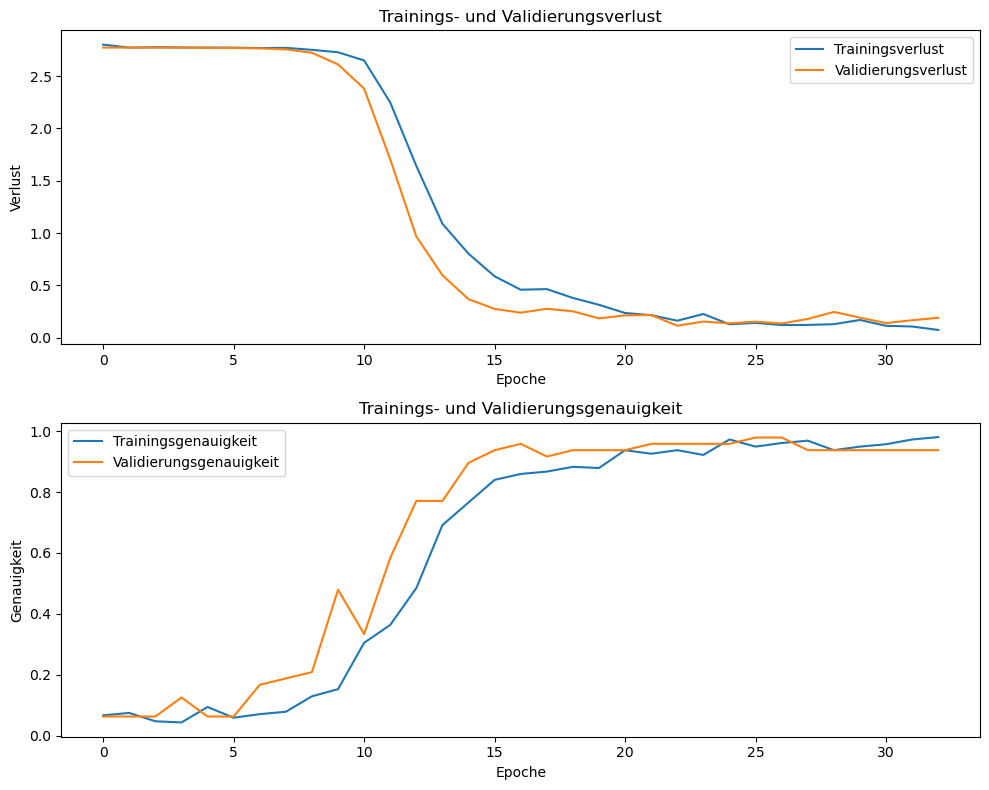

In [4]:
plt.figure(figsize=(10, 8))

# Verlust visualisieren
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Trainingsverlust')
plt.plot(history.history['val_loss'], label='Validierungsverlust')
plt.xlabel('Epoche')
plt.ylabel('Verlust')
plt.legend()
plt.title('Trainings- und Validierungsverlust')

# Genauigkeit visualisieren
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Trainingsgenauigkeit')
plt.plot(history.history['val_accuracy'], label='Validierungsgenauigkeit')
plt.xlabel('Epoche')
plt.ylabel('Genauigkeit')
plt.legend()
plt.title('Trainings- und Validierungsgenauigkeit')

plt.tight_layout()
plt.show()

## Anwendung auf Testdaten

Beginne die Vorhersagen für die Testdaten...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Vorhersagen abgeschlossen.
Anzahl der Vorhersagen: 32


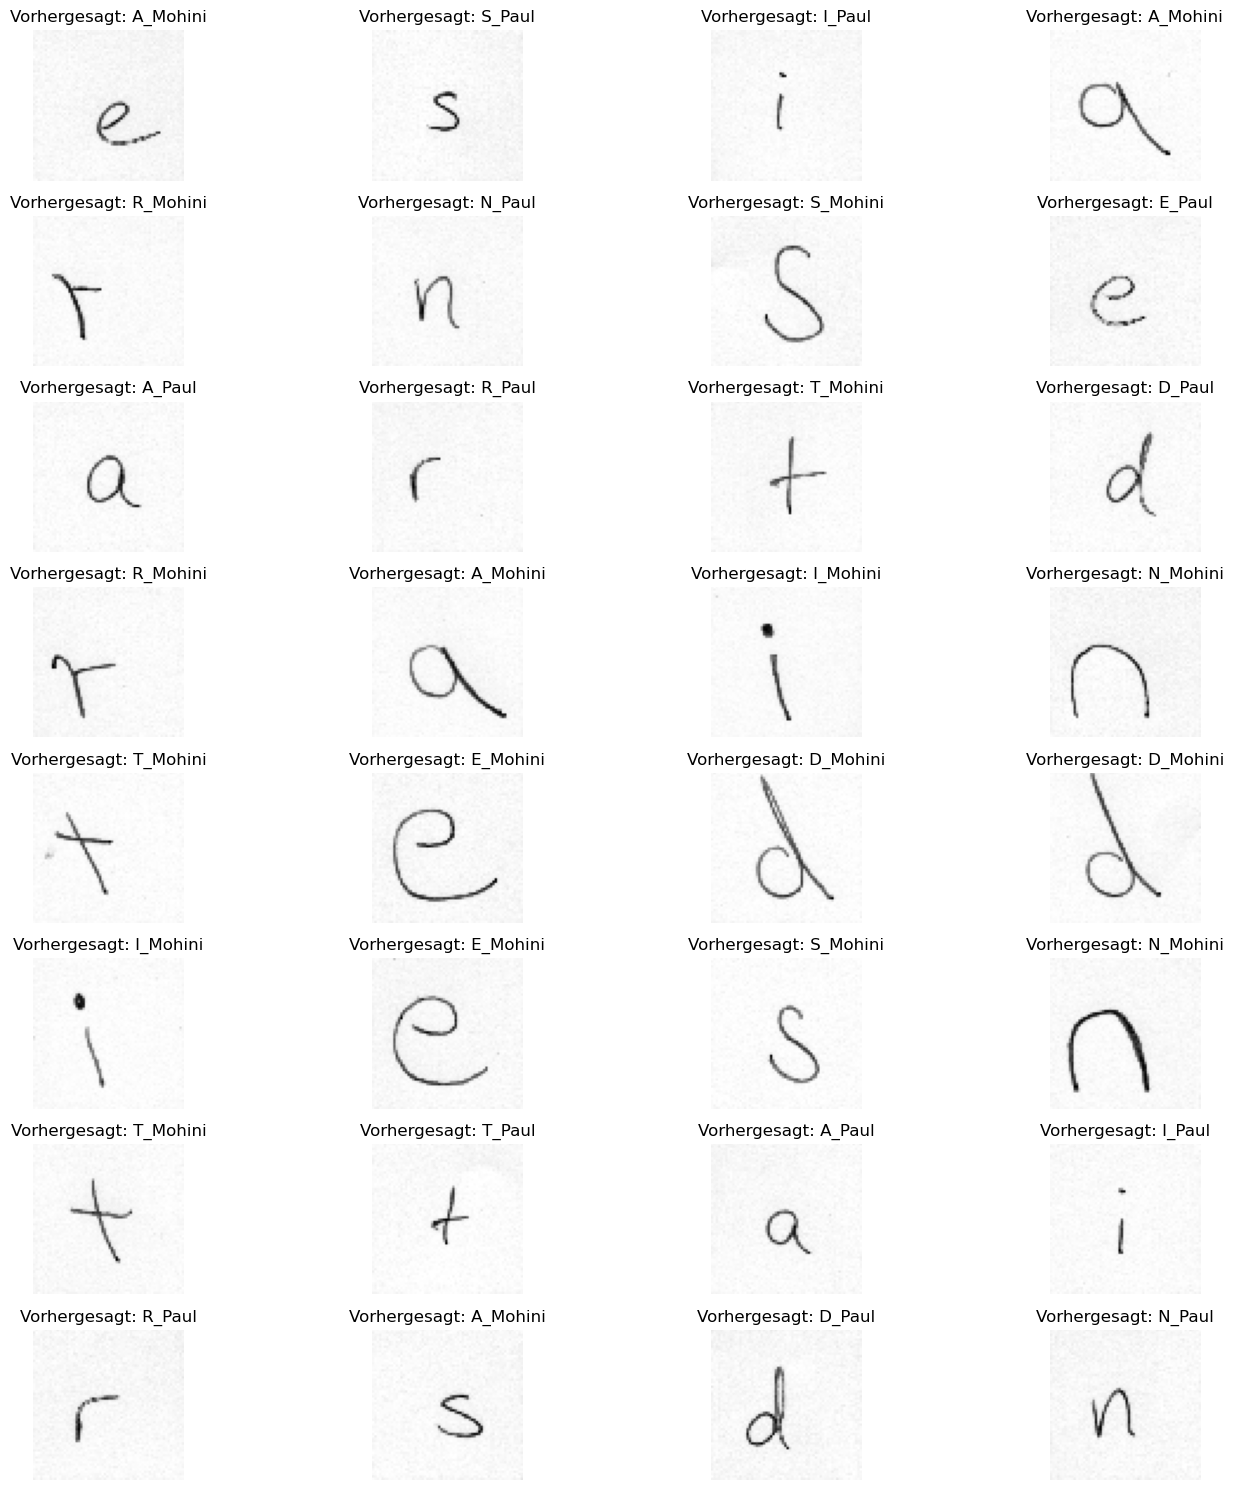

In [5]:
def load_test_images(test_dir, target_size=(64, 64)):
    images = []
    image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith('.png')]
    for img_path in image_paths:
        img = load_img(img_path, target_size=target_size, color_mode='grayscale')  # Laden als Graustufenbild
        img_array = img_to_array(img) / 255.0  
        images.append(img_array)
    return np.array(images), image_paths


test_dir = '/Users/mohini/Library/Mobile Documents/com~apple~CloudDocs/ML_Projekt_Handschrift/dataset/test'


test_images, test_image_paths = load_test_images(test_dir)

# Vorhersagen für die Testbilder machen
try:
    model = load_model('handwriting_model.h5')  
    print("Beginne die Vorhersagen für die Testdaten...")
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    print("Vorhersagen abgeschlossen.")
    print(f"Anzahl der Vorhersagen: {len(predicted_classes)}")

    # Bilder und Vorhersagen anzeigen
    plt.figure(figsize=(15, 15))
    for i in range(min(32, len(test_images))):  
        ax = plt.subplot(8, 4, i + 1)  
        plt.imshow(test_images[i].squeeze(), cmap='gray')  
        plt.title(f"Vorhergesagt: {class_names[predicted_classes[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Fehler bei der Vorhersage: {e}")